# Pytorch Autograd

Deep Learning means basically estimating some parameters set that would map a given input data distribution to a output distribution in an acceptable manner. No matter what the usecase is, in general sense this is what we try to achieve.

But as we know this require linear algebra and differenciation (means maths), and pytorch inherently support these mathematical operations.

To understand how these are working, lets check on a simple example.

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

Here assume we have a set of values `t_c` which should some how relate to another set of values `t_u`. Now our task is to identify the relationship between 2 such that if we have a `t_c` value we can predict the corresponding `t_u` value.

In [2]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

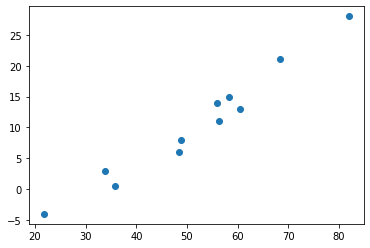

In [10]:
fig, ax = plt.subplots()
ax.scatter(t_u, t_c)
plt.show()

We can this linear model would fit here. So now what we do is basically try to fix a random linear model to this data and see how much error it would yield compared to actual data. From that error value we can identify how much we want to rectify our parameters.

In [12]:
def model(input_vals, w, b):
    return w*input_vals + b

def calc_error(pred_vals, true_vals):
    return ((pred_vals-true_vals)**2).mean() # Since we are using tensors, or we can use numpy functions here.

So now we have a model and a way to calculate errors. But to improve our model so that we can get lower error rate we need to do something else. Basically we have to get how each parameters effect the error outcome and adjust the parameters to reduce that effect. (Error minimization using derivative - gradient descent)

In [23]:
def d_error_pred(pred_vals, true_vals):
    diff = 2*(pred_vals-true_vals)/pred_vals.size(0)
    return diff

# linear function derivative over b
def d_pred_b(pred_vals, b):
    return 1.0

# linear function derivative over w
def d_pred_w(pred_vals, w):
    return pred_vals

def grad_calculation(pred_vals, true_vals, params):
    w, b = params
    d_l_p = d_error_pred(pred_vals, true_vals)

    d_p_b = d_pred_b(pred_vals, b)
    d_p_w = d_pred_w(pred_vals, w)

    # partial derivatives of Loss
    d_l_w = d_l_p*d_p_w
    d_l_b = d_l_p*d_p_b

    return torch.stack([d_l_w.sum(), d_l_b.sum()])

If you wonder why we are separately calculating the differenciation functions for this is simple linear equation, answer is for demonstration. The above separation of differentiation is due to partial derivatives for error function.

<center><image src="./contents/1.jpg" width="500px"/></center>


As you can probably remember in DL there are annoyingly large number of notations and these notations cause various confusions (like outputs after activations A, layers l, outputs before activations z etc). So to be aligned with those notations above calculations were done.

In [47]:
def training_loop(n_iter, learning_rate, params, input_vals, true_vals):
    
    for i in range(n_iter):
        w, b = params
        preds = model(input_vals, w, b)
        error = calc_error(preds, true_vals)

        # Backpropagation or differenciation process
        gradients = grad_calculation(preds, true_vals, params)

        # Updating parameters to compensate for error gradients
        params = params - learning_rate*gradients

        if(i%500==0):
            print(f"Iteration {i+1} completed with error value of {error} and gradient {gradients}")

    return params

In [40]:
training_loop(15, 1e-4, torch.tensor([1.0, 0.0]), t_u, t_c)

Iteration 1 completed with error value of 1763.884765625 and gradient tensor([4517.2964,   82.6000])
Iteration 11 completed with error value of 33.027652740478516 and gradient tensor([57.7695,  6.8204])


tensor([ 0.2484, -0.0257])

This is what basically happens in Machine learning or Deep Learning in general. But points to note is that if we use larger learning rate lets say 1e-2 then the error will not converge. Not only that if we print out the gradients in each iterations we can see the values are large. These are potential problems we need to fix or mitigate.

To do that, we can change learning rate or normalize input data (typical ML techniques).

In [50]:
t_un = 0.1*t_u
trained_params = training_loop(5000, 1e-2, torch.tensor([1.0, 0.0]), t_un, t_c)

Iteration 1 completed with error value of 80.36434173583984 and gradient tensor([-77.6140, -10.6400])
Iteration 501 completed with error value of 5.08172607421875 and gradient tensor([-0.2655,  1.5892])
Iteration 1001 completed with error value of 2.984950065612793 and gradient tensor([-0.0461,  0.2944])
Iteration 1501 completed with error value of 2.9287469387054443 and gradient tensor([-0.0064,  0.0416])
Iteration 2001 completed with error value of 2.927666664123535 and gradient tensor([-0.0008,  0.0056])
Iteration 2501 completed with error value of 2.927645683288574 and gradient tensor([-0.0001,  0.0008])
Iteration 3001 completed with error value of 2.927644968032837 and gradient tensor([-2.3007e-05,  9.2626e-05])
Iteration 3501 completed with error value of 2.927644968032837 and gradient tensor([-2.3007e-05,  9.2626e-05])
Iteration 4001 completed with error value of 2.927644968032837 and gradient tensor([-2.3007e-05,  9.2626e-05])
Iteration 4501 completed with error value of 2.9276

We can see that values converge significantly and output values greatly match the input values to output values.

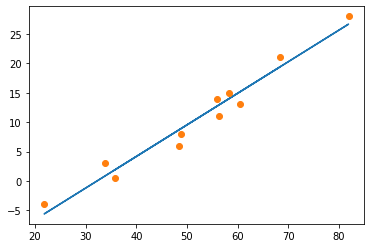

In [53]:
#predictions on trained params
t_p = model(t_un, trained_params[0], trained_params[1])


fig = plt.figure()
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

We can see that the trained parameters fit the input data very nicely. 

One of the major problems of implementations like above is we need to manually keep track of the operations and calculate the differentiation operations to calculate the error propagation throughout the functions. Our example is simple, so we could do the calculations ourselves. But in large networks this is not practical.

To solve this issue pytorch tensors provide us with autagrad functionality. (Threory behind this is not complex, but you need to find correct materials unless you are super smart to understand everything by reading wikipedia notes. XD). Because of this no matter how nested the forward calculation function is we can easily find derivatives to a related parameters. (In tensorflow we use `GradientTape` context manager for this by the way.)

Usage of autograd to our above problem is as below.

In [4]:
def model(input_vals, w, b):
    return w*input_vals + b

def calc_error(pred_vals, true_vals):
    return ((pred_vals-true_vals)**2).mean() # Since we are using tensors, or we can use numpy functions here.

Notice the `requires_grad` parameter. This tells pytorch to keep track of all the graph of tensor operations built on top of the params tensors. So any tensor that originated from params can access the chain of functions which used to create itself.

In [5]:
params = torch.tensor([1.0, 0.0], requires_grad=True)

In [6]:
params.grad is None

True

So now we have to do is do all the required operations and then call the backward function to calculate the gradients.

In [7]:
# pred_vals = model(t_u, *params)
error = calc_error(model(t_u*0.1, *params), t_c)
error.backward()

In [8]:
params.grad

tensor([-77.6140, -10.6400])

As you can see, params now contain the error derivative with respective to the parameters.

So demonstrated earlier we can calculate the derivative of any tensoe using `requires_grad` parameter.

**But there's a catch!** backward function calculate and accumulate the gradients in each call. Which means if we call backward function multiple times leaf tensors will have inaccurate values. So we need to explicitly make the gradient to zero.

In [10]:
if params.grad is not None:
    params.grad.zero_()
params

tensor([1., 0.], requires_grad=True)

The usage of this technique for previous example is below.

In [15]:
def training_loop(n_iter, learning_rate, params, input_vals, true_vals):
    
    for i in range(n_iter):

        if params.grad is not None:
            params.grad.zero_()

        w, b = params
        preds = model(input_vals, w, b)
        error = calc_error(preds, true_vals)

        # Backpropagation or differenciation process
        error.backward()

        # Updating parameters to compensate for error gradients
        with torch.no_grad():  # Have to use this condition to avoid graph building with param
            params -= learning_rate * params.grad

        if(i%500==0):
            print(f"Iteration {i+1} completed with error value of {error} and gradient {params.grad}")

    return params

In [18]:
training_loop(5000, 1e-2, torch.tensor([1.0, 0.0], requires_grad=True), t_un, t_c)

Iteration 1 completed with error value of 80.36434173583984 and gradient tensor([-77.6140, -10.6400])
Iteration 501 completed with error value of 7.843369007110596 and gradient tensor([-0.2248,  1.2726])
Iteration 1001 completed with error value of 3.8254828453063965 and gradient tensor([-0.0961,  0.5439])
Iteration 1501 completed with error value of 3.091630458831787 and gradient tensor([-0.0411,  0.2324])
Iteration 2001 completed with error value of 2.9575960636138916 and gradient tensor([-0.0176,  0.0993])
Iteration 2501 completed with error value of 2.9331159591674805 and gradient tensor([-0.0075,  0.0425])
Iteration 3001 completed with error value of 2.9286458492279053 and gradient tensor([-0.0032,  0.0181])
Iteration 3501 completed with error value of 2.9278290271759033 and gradient tensor([-0.0014,  0.0078])
Iteration 4001 completed with error value of 2.9276793003082275 and gradient tensor([-0.0006,  0.0033])
Iteration 4501 completed with error value of 2.927651882171631 and gr

tensor([  5.3671, -17.3012], requires_grad=True)

This is very convenient as we only require to build the forward pass.


Also additionally pytorch provides a submodule which provide different optimization algorithms.

In [19]:
import torch.optim as optim

dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'NAdam',
 'Optimizer',
 'RAdam',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional',
 '_multi_tensor',
 'lr_scheduler',
 'swa_utils']

So we can use this type optimizer to our models to improve efficiency.

In [20]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-5
optimizer = optim.SGD([params], lr=learning_rate)

preds = model(t_u, *params)
error = calc_error(preds, t_c)

optimizer.zero_grad() # We need to manually reset optimizers as well!
error.backward()
optimizer.step()
params

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)

As you can see, optmizers update the parameters without we having to manually adjust the parameter values (substract change).


> In scenarios we need to make sure autograd is not in effect we can use `with torch.no_grad()` context manager or `with torch.set_grad_enabled(val)` context manager.